# Informer model for Time Series Forecasting Time Series forecating

- long-term dependency가 없는 매우 단순한 주기성 패턴을 sample data로 설정하여 일반 Transformer 모델 성능이 더 좋게 나온 것을 확인할 수 있다.
- Epoch 30, Loss: 0.0919

### Import libraries

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Preparing sample time series data

In [2]:
# 기본 설정
np.random.seed(42)
torch.manual_seed(42)

# 1. 데이터 생성 (sin + noise)
t = np.arange(0, 500)
data = np.sin(0.05 * t) + 0.1 * np.random.randn(500)
data = data.reshape(-1, 1)

# 2. 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 3. 하이퍼파라미터 (Informer 스타일)
seq_len = 48        # encoder input
label_len = 24      # decoder input (context)
pred_len = 24       # decoder 예측 길이

def create_dataset(data, seq_len, label_len, pred_len):
    inputs, dec_inputs, targets = [], [], []
    L = len(data)
    for i in range(L - seq_len - pred_len):
        seq_x = data[i:i+seq_len]
        seq_y = data[i+seq_len-label_len:i+seq_len+pred_len]  # decoder 인풋 + 타겟
        dec_in = np.zeros_like(seq_y)
        dec_in[:label_len] = seq_y[:label_len]  # label_len만 넣고 나머지는 0
        inputs.append(seq_x)
        dec_inputs.append(dec_in)
        targets.append(seq_y[label_len:])  # 진짜 예측 대상
    return np.array(inputs), np.array(dec_inputs), np.array(targets)

X_enc, X_dec, y = create_dataset(data_scaled, seq_len, label_len, pred_len)

# Tensor 변환
X_enc = torch.tensor(X_enc, dtype=torch.float32).to(device)  # (N, seq_len, 1)
X_dec = torch.tensor(X_dec, dtype=torch.float32).to(device)  # (N, label_len+pred_len, 1)
y = torch.tensor(y, dtype=torch.float32).to(device)          # (N, pred_len, 1)

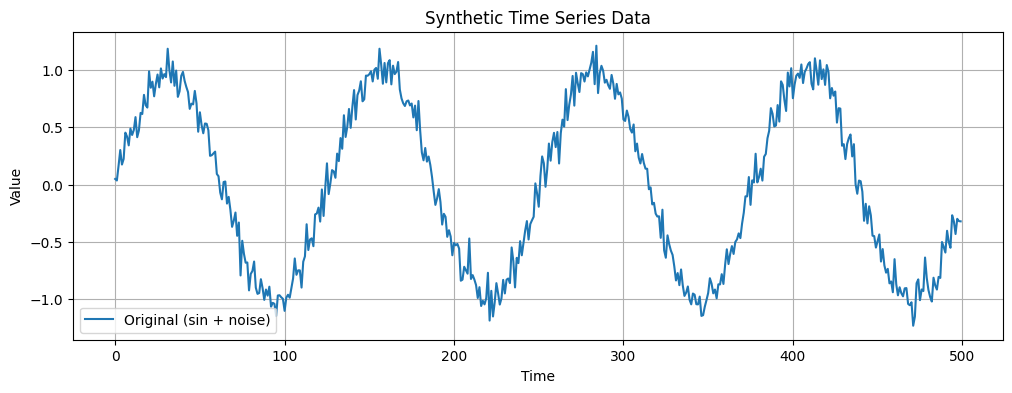

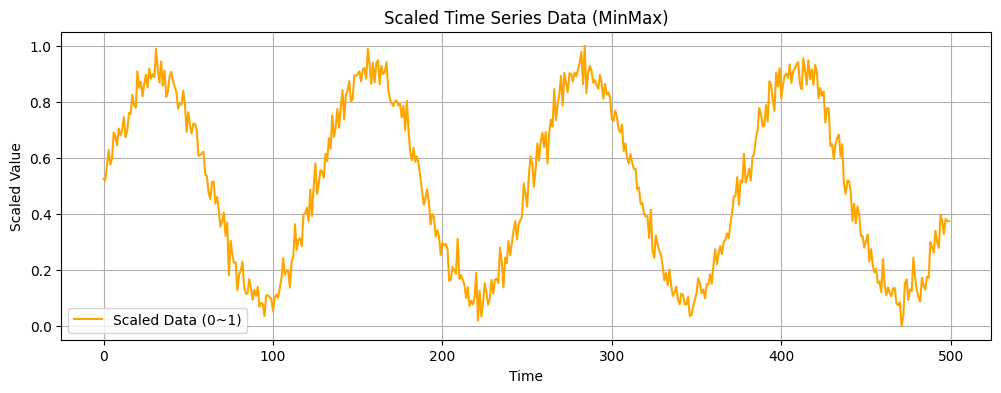

In [3]:
# 시계열 데이터 시각화 (정규화 전 원본)
plt.figure(figsize=(12, 4))
plt.plot(t, data, label="Original (sin + noise)")
plt.title("Synthetic Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# 시계열 데이터 시각화 (MinMaxScaler 적용 후)
plt.figure(figsize=(12, 4))
plt.plot(data_scaled, label="Scaled Data (0~1)", color='orange')
plt.title("Scaled Time Series Data (MinMax)")
plt.xlabel("Time")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.show()

### ProbSparseSelfAttention

In [4]:
class ProbSparseSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, queries, keys, values):
        B, L_q, _ = queries.size()
        B, L_k, _ = keys.size()
        H = self.n_heads
        D = self.head_dim

        q = self.q_proj(queries).view(B, L_q, H, D).transpose(1, 2)  # (B, H, L_q, D)
        k = self.k_proj(keys).view(B, L_k, H, D).transpose(1, 2)     # (B, H, L_k, D)
        v = self.v_proj(values).view(B, L_k, H, D).transpose(1, 2)   # (B, H, L_k, D)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(D)  # (B, H, L_q, L_k)
        attn = torch.softmax(scores, dim=-1)
        context = torch.matmul(attn, v)  # (B, H, L_q, D)

        out = context.transpose(1, 2).contiguous().view(B, L_q, H * D)
        return self.out_proj(out)

### EncoderLayer

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.self_attn = ProbSparseSelfAttention(d_model, n_heads)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_out = self.self_attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x

### DecoderLayer

In [6]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.self_attn = ProbSparseSelfAttention(d_model, n_heads)
        self.cross_attn = ProbSparseSelfAttention(d_model, n_heads)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out):
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x)))
        x = self.norm2(x + self.dropout(self.cross_attn(x, enc_out, enc_out)))
        x = self.norm3(x + self.dropout(self.ff(x)))
        return x

### Informer

In [ ]:
class Informer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, e_layers, d_layers,
                 input_window, output_window):
        super().__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, input_window, d_model))

        self.encoder = nn.Sequential(*[EncoderLayer(d_model, nhead) for _ in range(e_layers)])

        self.decoder_input = nn.Parameter(torch.randn(1, output_window, d_model))
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, nhead) for _ in range(d_layers)])

        self.projection = nn.Linear(d_model, output_dim)

    def forward(self, x_enc):
        B = x_enc.size(0)
        enc_input = self.input_embedding(x_enc) + self.pos_embedding  # (B, input_len, d_model)
        enc_out = self.encoder(enc_input)

        dec_input = self.decoder_input.repeat(B, 1, 1)
        for layer in self.decoder_layers:
            dec_input = layer(dec_input, enc_out)
        dec_out = dec_input
        
        out = self.projection(dec_out)
        return out


### Hyperparameter Setting and Model Initialization

In [8]:
# 하이퍼파라미터 설정
input_dim = 1              # 입력 차원
output_dim = 1             # 출력 차원
d_model = 64               # 임베딩 차원
nhead = 4                  # 헤드 수
e_layers = 2               # 인코더 레이어 수
d_layers = 1               # 디코더 레이어 수
input_window = 48          # 인코더 입력 길이
output_window = 24         # 예측 길이 (디코더 출력)


# Informer 모델 (앞서 정의한 것 사용: input_len=seq_len, output_len=pred_len)
model = Informer(
    input_dim=input_dim,
    output_dim=output_dim,
    d_model=d_model,
    nhead=nhead,
    e_layers=e_layers,
    d_layers=d_layers,
    input_window=input_window,
    output_window=output_window
).to(device)

### Training the Model

In [9]:
# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_enc)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    # 모든 에포크 출력
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 1.0066
Epoch 2, Loss: 0.4828
Epoch 3, Loss: 0.5803
Epoch 4, Loss: 0.4671
Epoch 5, Loss: 0.2927
Epoch 6, Loss: 0.2045
Epoch 7, Loss: 0.2092
Epoch 8, Loss: 0.2216
Epoch 9, Loss: 0.1932
Epoch 10, Loss: 0.1435
Epoch 11, Loss: 0.1083
Epoch 12, Loss: 0.1048
Epoch 13, Loss: 0.1206
Epoch 14, Loss: 0.1359
Epoch 15, Loss: 0.1342
Epoch 16, Loss: 0.1204
Epoch 17, Loss: 0.1075
Epoch 18, Loss: 0.1014
Epoch 19, Loss: 0.1070
Epoch 20, Loss: 0.1147
Epoch 21, Loss: 0.1183
Epoch 22, Loss: 0.1119
Epoch 23, Loss: 0.1030
Epoch 24, Loss: 0.0965
Epoch 25, Loss: 0.0927
Epoch 26, Loss: 0.0948
Epoch 27, Loss: 0.0974
Epoch 28, Loss: 0.0972
Epoch 29, Loss: 0.0953
Epoch 30, Loss: 0.0919


### Prediction -> Post-processing

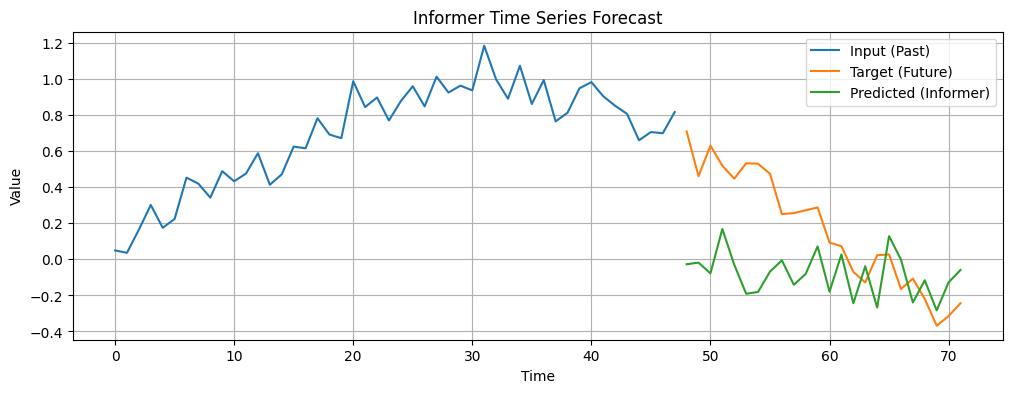

In [12]:
# 예측 (첫 번째 샘플로 테스트)
model.eval()
with torch.no_grad():
    sample_input = X_enc[0].unsqueeze(0)  # (1, seq_len, 1)
    pred = model(sample_input)           # (1, pred_len, 1)

# 시각화
input_orig = scaler.inverse_transform(sample_input.squeeze(0).cpu().numpy())
target_orig = scaler.inverse_transform(y[0].squeeze(0).cpu().numpy())
pred_orig = scaler.inverse_transform(pred.squeeze(0).cpu().numpy())

plt.figure(figsize=(12, 4))
plt.plot(np.arange(seq_len), input_orig, label='Input (Past)')
plt.plot(np.arange(seq_len, seq_len + pred_len), target_orig, label='Target (Future)')
plt.plot(np.arange(seq_len, seq_len + pred_len), pred_orig, label='Predicted (Informer)')
plt.title("Informer Time Series Forecast")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# save and show
plt.savefig("sin_result/Informer_sin_function_forecast.png", bbox_inches='tight')
plt.show()

### END